In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

labels = ['Use_telephone','Standup_chair','Walk','Climb_stairs','Sitdown_chair','Brush_teeth','Comb_hair','Eat_soup','Pour_water','Descend_stairs','Eat_meat','Drink_glass', 'Getup_bed', 'Liedown_bed']
fit_map = {}
for label in labels:
    path = "HMP_Dataset/"+label+"/"
    files = os.listdir(path)
    file_list = []
    for file in files:
        if not os.path.isdir(file):
            addr = path+file
            fit_df = pd.read_table(addr,sep=",",header=None)
            file_list.append(fit_df)
    fit_map[label] = file_list

In [2]:
# Seperate the data set into train_set, validation_set and test_set in the ratio of 70%,15% and 15%
fit_train = {}
fit_validate = {}
fit_test = {}
for label in fit_map:
    train_list, rest_list = train_test_split(fit_map[label],test_size=0.3)
    vali_list, test_list = train_test_split(rest_list,test_size=0.5)
    fit_train[label] = train_list
    fit_validate[label] = vali_list
    fit_test[label] = test_list

In [3]:
# slice_ is used to slice the data set into a fixed length vector of size n.
def slice_(dic,n):
    new_map = {}
    for label in dic:
        list0 = []
        for elem in dic[label]:
            slice_list = []
            rows = elem.shape[0]
            i = 0
            while rows>n-1:
                inner_list = []
                arr = elem[n*i:n*(i+1)].values
                for a in arr:
                    temp = a[0].split()
                    temp = list(map(int,temp))
                    for value in temp:
                        inner_list.append(value)
                slice_list.append(inner_list)
                rows = rows-n
                i = i+1
            list0.append(slice_list)
        new_map[label] = list0
    return new_map

# merge_ is used to merge all the data into one set, making preparations for K-means.
def merge_(dic):
    list_all = []
    for label in dic:
        for arr in dic[label]:
            for elem in arr:
                list_all.append(elem)
    return list_all

In [4]:

# feature is a helper function for vq, is to get the feature vector of each data set.
def feature(txt,size):
    lst = np.zeros(size)
    pre = kmeans.predict(txt)
    for elem in pre:      
        lst[elem] +=1
    return lst

# vector quantization, return a list containing all the feature vectors.
def vq(dic,n):
    new_list = []
    for label in dic:
        for v in dic[label]:
            new = feature(v,n)
            new_list.append(new)
    return new_list

def get_label(dic):
    new_list = []
    n = 0
    for label in dic:
        for v in dic[label]:
            new_list.append(n)
        n += 1
    return new_list

# This function is used to compute the accuracy.
def compute_acc(lst1,lst2):
    n = len(lst1)
    sum = 0
    for i in range(n):
        if lst1[i]==lst2[i]:
            sum += 1
    return sum/n

In [5]:
# This is the validation of k value and three different classifiers conresponding to the accuracy.

train_slice = slice_(fit_train,11)
validate_slice = slice_(fit_validate,11)
test_slice = slice_(fit_test,11)
train_list = merge_(train_slice)

# Three lists to store the data of 3 classifiers.
acc_list1 = []
acc_list2 = []
acc_list3 = []
clf_r = RandomForestClassifier()
clf_s = SVC(gamma='auto')
clf_n = GaussianNB()

# Record the accuracy when k is from 2 to 40.
for i in range(2,40):
    kmeans = KMeans(n_clusters=i).fit(train_list)
    label_p = get_label(train_slice)
    data_p = vq(train_slice,i)
    clf_r.fit(data_p,label_p)
    clf_s.fit(data_p,label_p)
    clf_n.fit(data_p,label_p)
    vali_label = get_label(validate_slice)
    vali_data = vq(validate_slice,i)
    predict1 = clf_r.predict(vali_data)
    predict2 = clf_s.predict(vali_data)
    predict3 = clf_n.predict(vali_data)
    accuracy1 = compute_acc(predict1,vali_label)
    accuracy2 = compute_acc(predict2,vali_label)
    accuracy3 = compute_acc(predict3,vali_label)
    acc_list1.append(accuracy1)
    acc_list2.append(accuracy2)
    acc_list3.append(accuracy3)

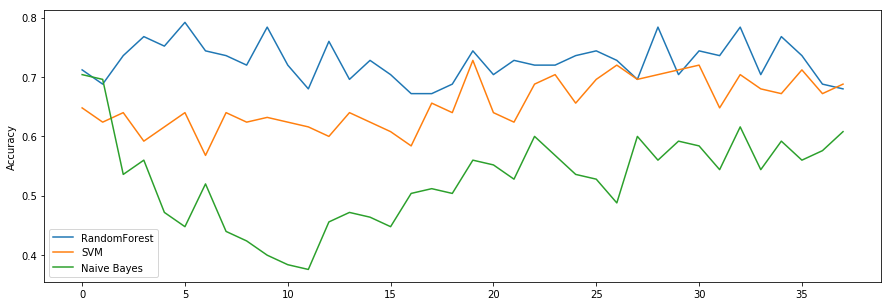

In [6]:
plt.figure(figsize=(15,5))
plt.plot(acc_list1,label='RandomForest')
plt.plot(acc_list2,label='SVM')
plt.plot(acc_list3,label='Naive Bayes')
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [7]:
# This part is to validate the d value.
train_slice = slice_(fit_train,11)
validate_slice = slice_(fit_validate,11)
test_slice = slice_(fit_test,11)
train_list = merge_(train_slice)
# max_k is the k value corresponding to the biggest accuracy from the above range.
max_k = acc_list1.index(max(acc_list1))+2

acc_d = []
clf_r = RandomForestClassifier()

# Validate d value from 30 to 90, increase by 3 each time.
for i in range(10,30):
    train_slice = slice_(fit_train,i)
    train_list = merge_(train_slice)
    validate_slice = slice_(fit_validate,i)
    kmeans = KMeans(n_clusters=max_k).fit(train_list)
    label_p = get_label(train_slice)
    data_p = vq(train_slice,max_k)
    clf_r.fit(data_p,label_p)
    vali_label = get_label(validate_slice)
    vali_data = vq(validate_slice,max_k)
    predict1 = clf_r.predict(vali_data)
    accuracy1 = compute_acc(predict1,vali_label)
    acc_d.append(accuracy1)

No handles with labels found to put in legend.


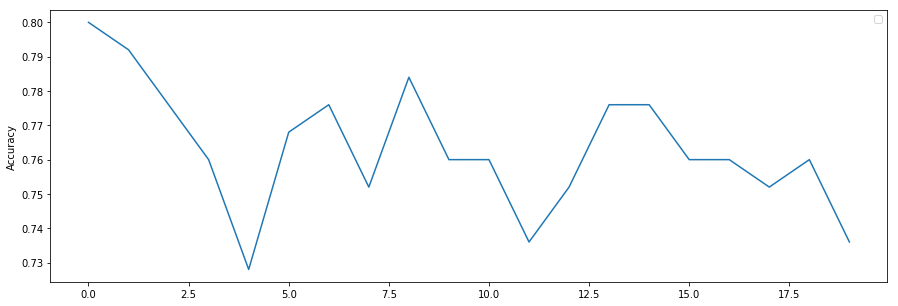

In [8]:
plt.figure(figsize=(15,5))
plt.plot(acc_d)
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
max_d = (acc_d.index(max(acc_d))+10)*3  #the d value corresponding to the biggest accuracy

# The last part is test the classier and check the accuracy.
print("max_d: "+str(max_d))
print("max_k: "+str(max_k))
train_slice = slice_(fit_train,max_d)
test_slice = slice_(fit_test,max_d)
train_list = merge_(train_slice)
kmeans = KMeans(n_clusters=max_k).fit(train_list)
label_p = get_label(train_slice)
data_p = vq(train_slice,max_k)
clf_r.fit(data_p,label_p)
test_label = get_label(test_slice)
test_data = vq(test_slice,max_k)
predict = clf_r.predict(test_data)
print(metrics.confusion_matrix(predict, test_label))
accu = compute_acc(predict,test_label)
error = 1-accu
print("Accuracy: "+str(accu))
print("Error rate: "+str(error))
print(metrics.classification_report(predict, test_label))

max_d: 30
max_k: 7
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  0  0  6  0  0  0  0  2  0  0  2  2]
 [ 0  0 14  2  0  0  0  0  0  1  0  0  0  0]
 [ 0  2  1 14  0  0  0  0  0  3  0  0  2  0]
 [ 0  3  0  0  8  1  0  0  0  0  0  0  2  1]
 [ 0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0  0  1  1  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 2  0  0  0  0  0  1  0  0  0  0 14  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0  8  2]
 [ 0  0  0  0  1  0  0  0  0  0  0  0  1  0]]
Accuracy: 0.6946564885496184
Error rate: 0.30534351145038163
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         0
          1       0.62      0.45      0.53        22
          2       0.93      0.82      0.87        17
          3       0.88      0.64      0.74        22
          4       0.53 

/Users/kaihanshen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
